<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Семинар. Generative adversarial networks</b></h3>



# New Section

В этом ноутбуке мы попробуем обучить GAN генерировать морды кошек из случайного шума. Датасет с кошками взят отсюда:
https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models

In [8]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [17]:
! rm -r cats

In [ ]:
!unzip archive.zip

In [22]:
DATA_DIR = './cats/'

In [27]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Подготовим наши изображения к дальнейшему использованию

In [28]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [29]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [30]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [31]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Посмотрим, как выглядит батч

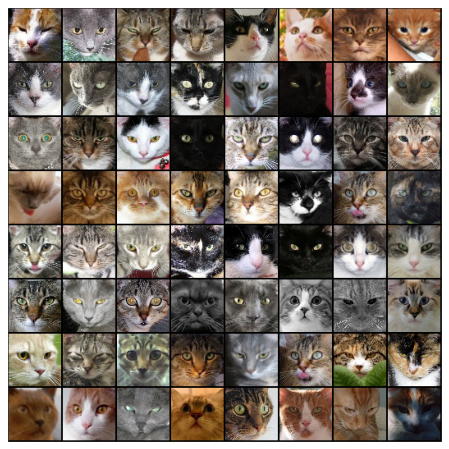

In [32]:
show_batch(train_dl)

In [33]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [35]:
train_dl = DeviceDataLoader(train_dl, device)

Давайте перейдем непосредственно к построению GANа. Напомним, что GAN состоит из двух сетей: *генератора*, задача которого – научиться генерировать изображения, похожие на обучающую выборку, из случайного шума, и *дискриминатора*, который учится распознавать, настоящее это изображение или сгенерированное генератором.

Построим генератор и дискриминатор на свертках:

In [40]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [41]:
discriminator = to_device(discriminator, device)

In [42]:
latent_size = 128

In [43]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Посмотрим, как выглядит шум, из которого будут генерироваться изображения

torch.Size([128, 3, 64, 64])


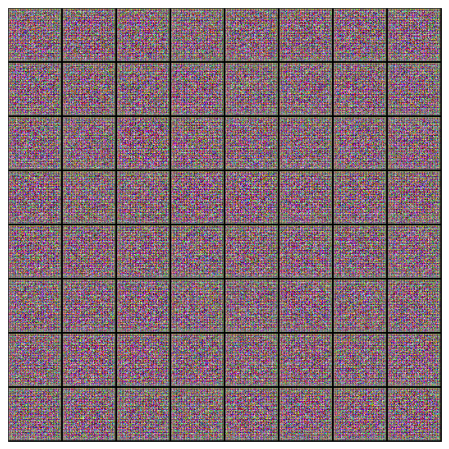

In [45]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [46]:
generator = to_device(generator, device)

In [47]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [48]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [49]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [71]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train() # переводим модели в режим обучения (нужно для BatchNorm)
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = { # оптимизаторы градиентного спуска
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad() # обнуляем градиенты дискриминатора

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images) # форвард пасс через дискриминатор
            real_targets = torch.ones(real_images.size(0), 1, device=device) # создаем лейблы для реальных фото (1)
            real_loss = criterion["discriminator"](real_preds, real_targets) # BCE loss между фотографиями
            cur_real_score = torch.mean(real_preds).item() # мат. ожидание предсказаний 1 на реальных фото
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device) #создаем латентный вектор latent_size x 1 x 1
            fake_images = model["generator"](latent) # семплируем котов

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device) # лейблы для фейковых изображений (0)
            fake_preds = model["discriminator"](fake_images) # предсказания для фейковых котов
            fake_loss = criterion["discriminator"](fake_preds, fake_targets) # лосс предсказаний что фейк - это фейк
            cur_fake_score = torch.mean(fake_preds).item() # мат. ожидание предсказания, что фейк - это фейк

            real_score_per_epoch.append(cur_real_score) # логирование, что правда - это правда
            fake_score_per_epoch.append(cur_fake_score) # логирование, что фейк - это фейк

            # Update discriminator weights
            loss_d = real_loss + fake_loss # скалдываем лоссы на правде и на феке
            loss_d.backward() # обратное распространение ошибки
            optimizer["discriminator"].step() # шаг градиентного спуска
            loss_d_per_epoch.append(loss_d.item()) # логируем суммарный лосс дискриминатора (УМ дискриминатора)


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad() # обнуляем градиенты генератора
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device) # создаем батч латентных векторов
            fake_images = model["generator"](latent) # генерация фейковых изображений
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images) # классифицируем фейковые изображения
            targets = torch.ones(batch_size, 1, device=device) # пусть фейки станут правдой
            loss_g = criterion["generator"](preds, targets) # посчитали "фейковый" лосс
            
            # Update generator weights
            loss_g.backward() # как сделать так, чтобы фейки были еще больше правдой? -> пробрасываем градиенты до генератора
            optimizer["generator"].step() # делаем шаг градиентного спуска генератором
            loss_g_per_epoch.append(loss_g.item()) # логируем лосс того, что фейк - это правда (УМ генератора) [чем меньше тем лучше т.к лосс]
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch)) # лосс генератора за эпоху
        losses_d.append(np.mean(loss_d_per_epoch)) # лосс дискриминатора за эпоху
        real_scores.append(np.mean(real_score_per_epoch)) # лосс дискримнатора на датасете
        fake_scores.append(np.mean(fake_score_per_epoch)) # лосс дискриминатора на семплированных данных
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1: # сохраняем последние фейковые img на последней эпохе
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [72]:
model = { # словарь моделей
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = { # словарь лоссов
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.0002
epochs = 20

In [73]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 6.6587, loss_d: 0.1113, real_score: 0.9608, fake_score: 0.0408


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 7.9327, loss_d: 0.1732, real_score: 0.9491, fake_score: 0.0474


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 7.9237, loss_d: 0.0789, real_score: 0.9725, fake_score: 0.0357


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 10.1866, loss_d: 0.2700, real_score: 0.9539, fake_score: 0.0388


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 7.2276, loss_d: 0.1499, real_score: 0.9499, fake_score: 0.0480


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 7.2287, loss_d: 0.2237, real_score: 0.9403, fake_score: 0.0652


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 8.8048, loss_d: 0.0758, real_score: 0.9733, fake_score: 0.0290


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 8.8116, loss_d: 0.2586, real_score: 0.9313, fake_score: 0.0665


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 7.9612, loss_d: 0.1614, real_score: 0.9578, fake_score: 0.0429


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 7.8353, loss_d: 0.2265, real_score: 0.9422, fake_score: 0.0582


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 7.2493, loss_d: 0.1410, real_score: 0.9575, fake_score: 0.0449


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 8.1022, loss_d: 0.1144, real_score: 0.9594, fake_score: 0.0410


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 8.2176, loss_d: 0.1084, real_score: 0.9640, fake_score: 0.0360


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 8.8457, loss_d: 0.0729, real_score: 0.9740, fake_score: 0.0282


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.4158, loss_d: 0.2278, real_score: 0.9455, fake_score: 0.0512


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 6.9304, loss_d: 0.1580, real_score: 0.9550, fake_score: 0.0481


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 7.7892, loss_d: 0.1075, real_score: 0.9645, fake_score: 0.0358


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 7.7649, loss_d: 0.1415, real_score: 0.9526, fake_score: 0.0454


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 7.0723, loss_d: 0.1053, real_score: 0.9604, fake_score: 0.0356


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 7.6300, loss_d: 0.1451, real_score: 0.9543, fake_score: 0.0514
Saving generated-images-0020.png


Посмотрим на результаты обучения. Вот так выглядят котики, сгенерированные на последней эпохе обучения:

In [76]:
losses_g, losses_d, real_scores, fake_scores = history

In [77]:
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

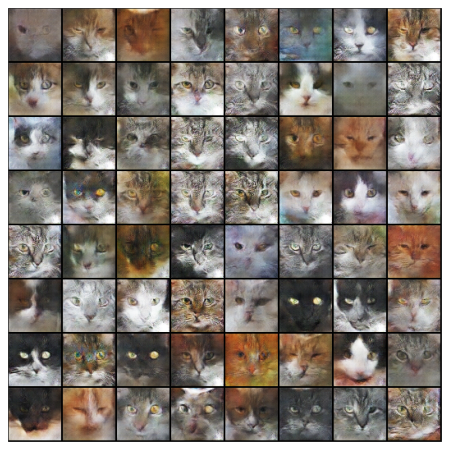

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Как мы видим, изображение в целом получается похожим, однако есть много артефактов

Посмотрим на графики loss генератора и дискриминатора и score дискриминатора

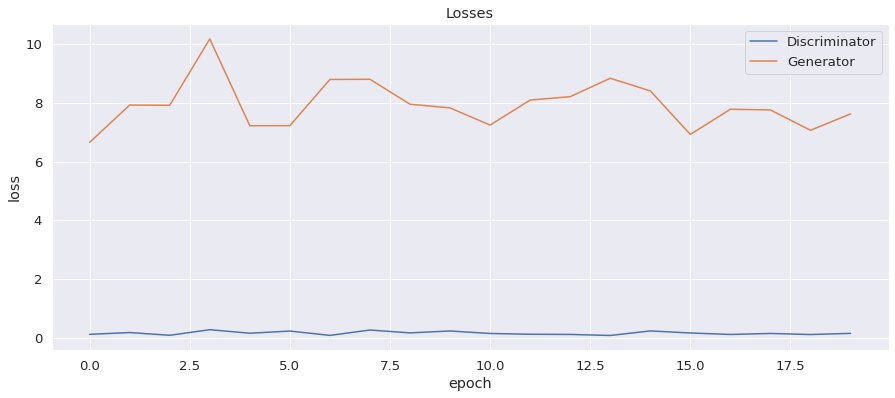

In [79]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

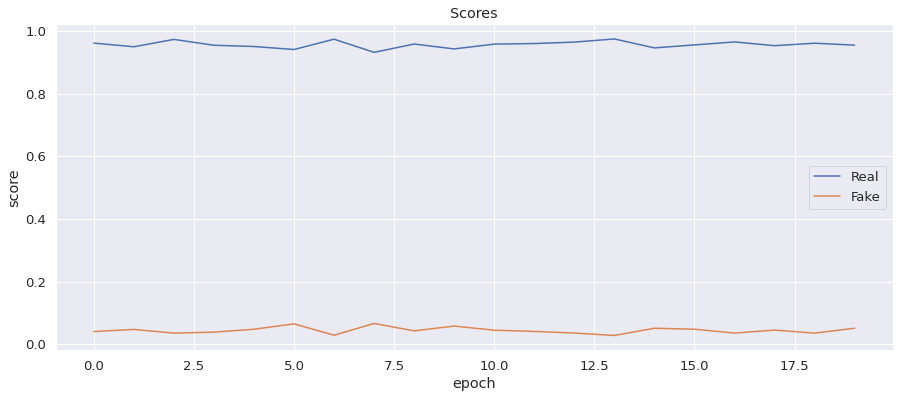

In [80]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Поведение графиков примерно такое же, как было показано на лекции